In [ ]:
import numpy as np
import matplotlib.pyplot as plt

Rótulos que a rede soltará:
(1,0) - Apneia
(0,1) - Não Aneia

# importando dados

In [ ]:
from os import listdir

In [ ]:
path = r"C:\Users\alexv\PycharmProjects\OmniSaude-IA\Data\Dataset/"
list_ = listdir(path)

In [ ]:
# carregando os dados de forma separada, pois a intencao é gerar arrays de cada classe
apneias = []
respiracoes = []

for ap in list_:
    if "respiracao" in ap and not("calibracao" in ap):
        respiracoes.append(np.load(path + ap))
    elif "apneia" in ap and not("calibracao" in ap):
        apneias.append(np.load(path+ap))


In [ ]:
to_pop = None
for idx in range(len(apneias)):
    if len(apneias[idx]) == 115:
        to_pop = idx

In [ ]:
_ = apneias.pop(to_pop)  # removendo um exemplo com quantidade menor de pacotes, apenas comodidade

In [ ]:
print(f"Quantidade de exemplos de apneias: {len(apneias)}")

Quantidade de exemplos de apneias: 48


In [ ]:
print(f"Quantidade de exemplos de respiracao: {len(respiracoes)}")

Quantidade de exemplos de respiracao: 49


### Gerando numpy arrays dos dados de cada classe

In [ ]:
apneias = np.array(apneias)

In [ ]:
respiracoes = np.array(respiracoes)

In [ ]:
# verificando o shape dos arrays
apneias.shape

(48, 135, 300, 57)

In [ ]:
respiracoes.shape

(49, 436, 300, 57)

> Entendendo o shape dos arrays:

> (numero_capturas, numero_janelas_amostras, tamanho_janela_pkts, subportadoras)

## Visualizando exemplos

In [ ]:
from random import randint, sample

Text(0.5, 1.0, 'Apneias')

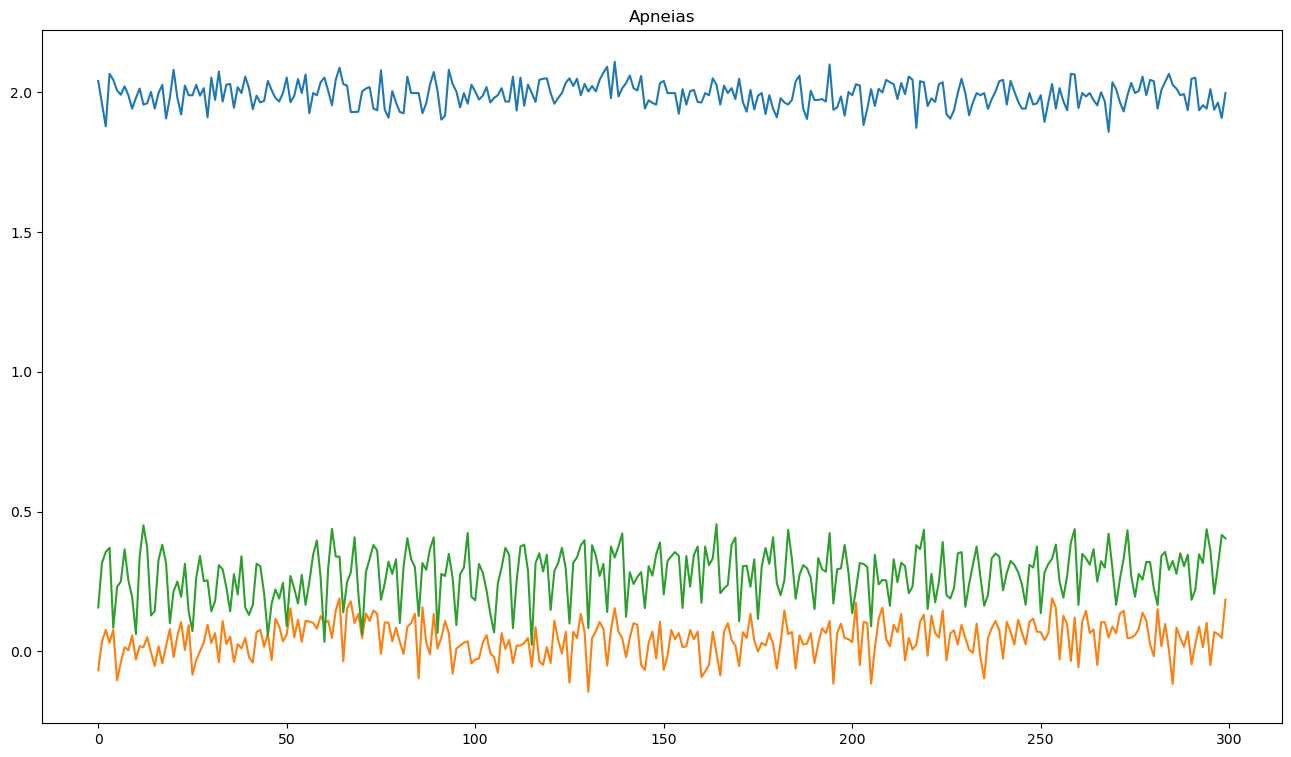

In [ ]:
# apneias

def rand():
    rand1 = randint(0, 47)
    rand2 = randint(0, 134)
    return rand1, rand2

rand1,rand2 = rand()
exemplo_1 = apneias[rand1, rand2, :, 0]
rand1,rand2 = rand()
exemplo_2 = apneias[rand1, rand2, :, 0]
rand1,rand2 = rand()
exemplo_3 = apneias[rand1, rand2, :, 0]

plt.figure(figsize=(16, 9))
plt.plot(exemplo_1, label="Exemplo 1")
plt.plot(exemplo_2, label="Exemplo 2")
plt.plot(exemplo_3, label="Exemplo 3")
plt.title("Apneias")

> Podemos perceber que cada exemplo tem um valor em y diferente, o que é uma questão inerente ao problema que estamos abordando! A diferença de fase não tem um range específico e bem definido que pode atuar.

> A solução que penso é tirar a média da janela. Pois assim nós mantemos o comportamento característico da onda, mas ao mesmo tempo trazemos para perto de 0. Ou simplesmente reescalar as ondas para entre 0 e 1 -> min max scaler.

In [ ]:
# criando um min max scaler eficiente
def minmax_scaler(data):
    data_min = data.min()
    data_max = data.max()
    data_range = data_max - data_min

    return (data - data_min)/data_range

Text(0.5, 1.0, 'Apneias')

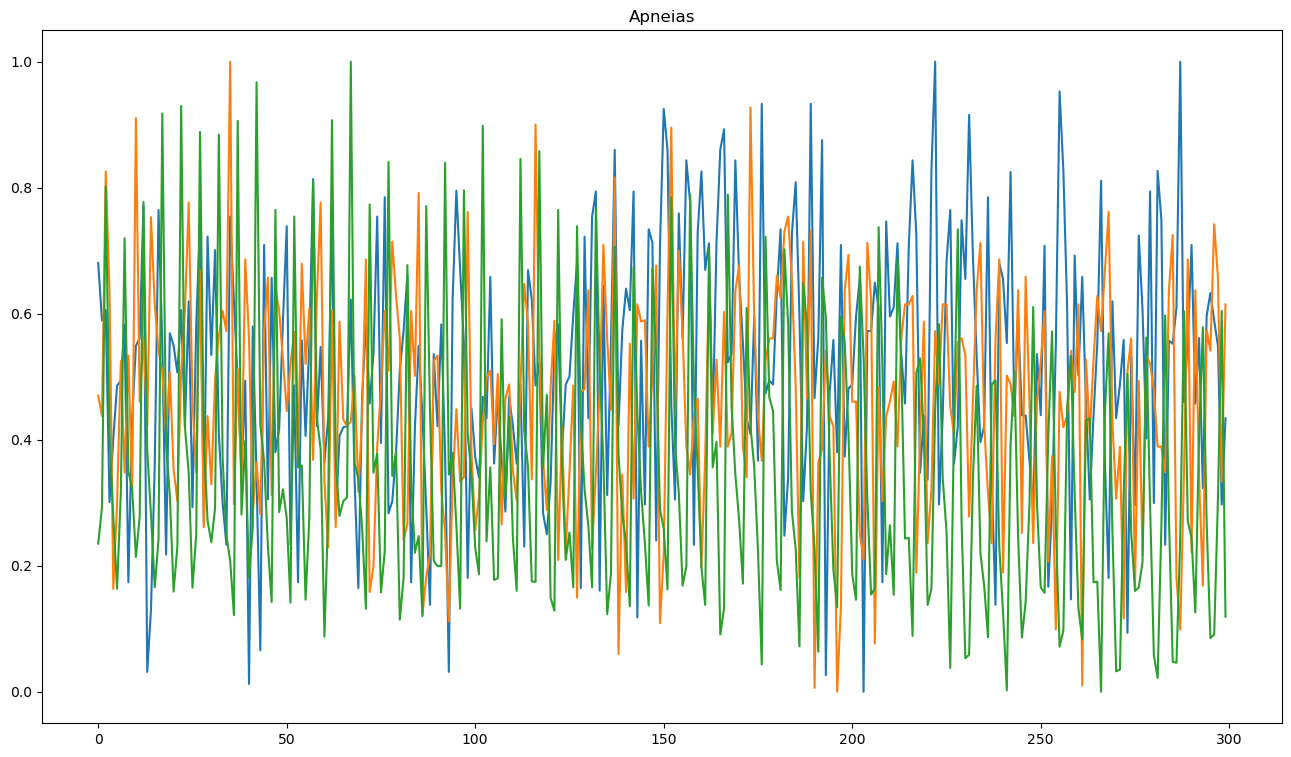

In [ ]:
# averiguando o mesmo view com min max aplicado
# apneias

rand1,rand2 = rand()
exemplo_1 = minmax_scaler(apneias[rand1, rand2, :, 0])
rand1,rand2 = rand()
exemplo_2 = minmax_scaler(apneias[rand1, rand2, :, 0])
rand1,rand2 = rand()
exemplo_3 = minmax_scaler(apneias[rand1, rand2, :, 0])

plt.figure(figsize=(16, 9))
plt.plot(exemplo_1, label="Exemplo 1")
plt.plot(exemplo_2, label="Exemplo 2")
plt.plot(exemplo_3, label="Exemplo 3")
plt.title("Apneias")

> De fato há mudanças.

Text(0.5, 1.0, 'Respiracoes')

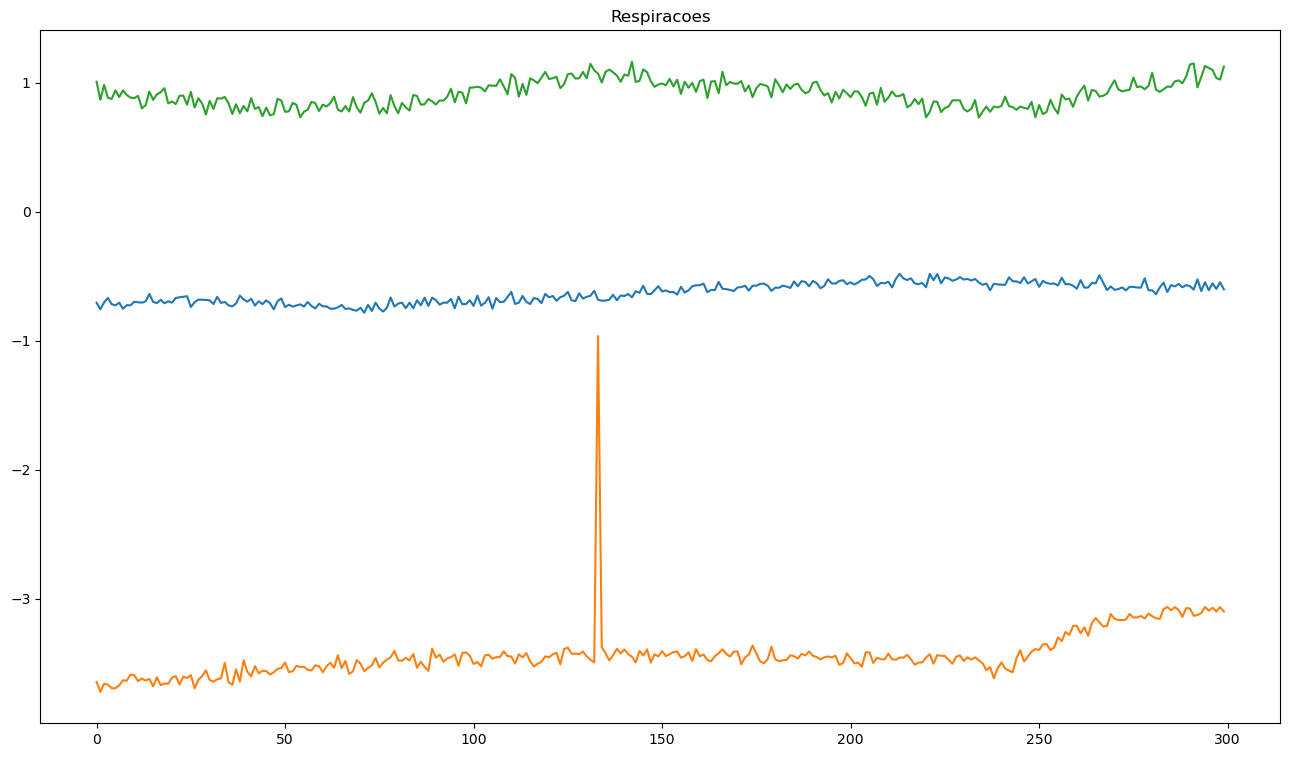

In [ ]:
# visualizando respiração

def rand():
    rand1 = randint(0, 48)
    rand2 = randint(0, 435)
    return rand1, rand2


rand1,rand2 = rand()
exemplo_1 = respiracoes[rand1, rand2, :, 0]
rand1,rand2 = rand()
exemplo_2 = respiracoes[rand1, rand2, :, 0]
rand1,rand2 = rand()
exemplo_3 = respiracoes[rand1, rand2, :, 0]

plt.figure(figsize=(16, 9))
plt.plot(exemplo_1, label="Exemplo 1")
plt.plot(exemplo_2, label="Exemplo 2")
plt.plot(exemplo_3, label="Exemplo 3")
plt.title("Respiracoes")

> Acende um alerta: o que fazer com exemplos que não parecem ter variação?

Text(0.5, 1.0, 'Respiracoes')

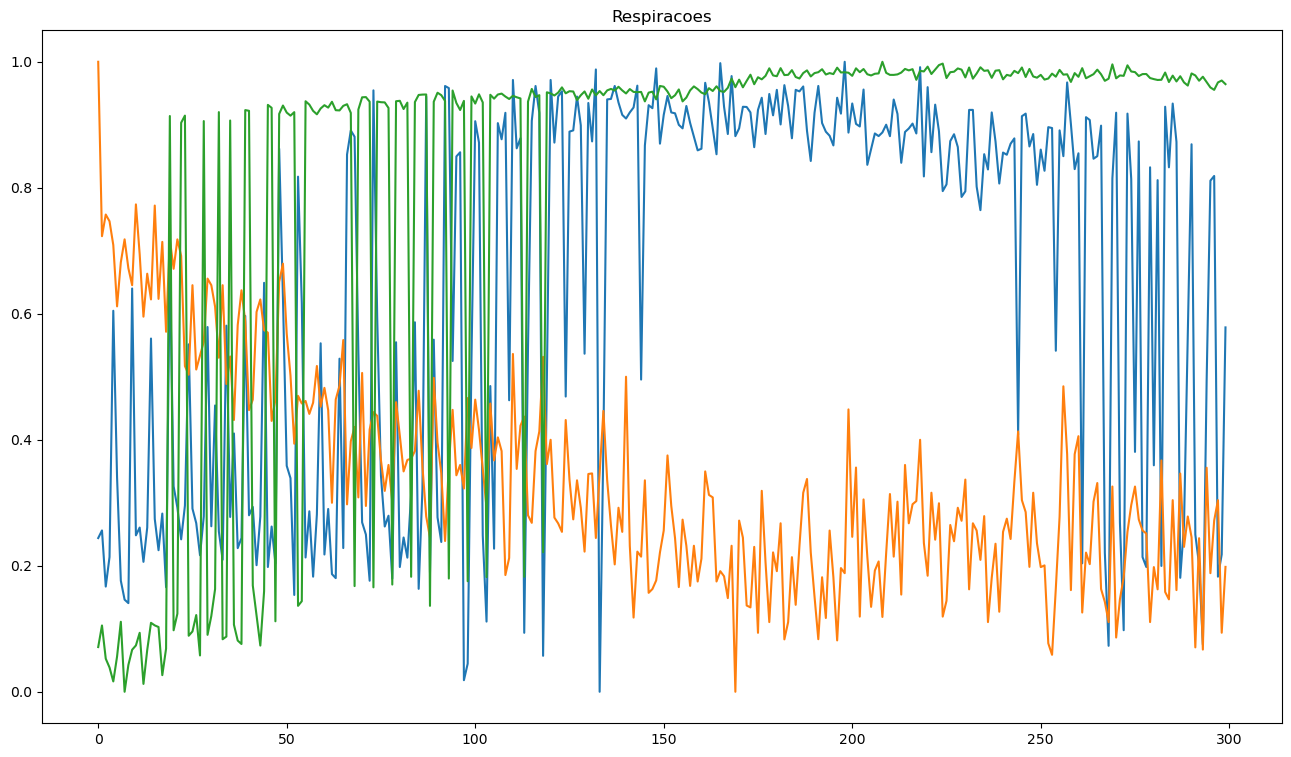

In [ ]:
# min max:

rand1,rand2 = rand()
exemplo_1 = minmax_scaler(respiracoes[rand1, rand2, :, 0])
rand1,rand2 = rand()
exemplo_2 = minmax_scaler(respiracoes[rand1, rand2, :, 0])
rand1,rand2 = rand()
exemplo_3 = minmax_scaler(respiracoes[rand1, rand2, :, 0])

plt.figure(figsize=(16, 9))
plt.plot(exemplo_1, label="Exemplo 1")
plt.plot(exemplo_2, label="Exemplo 2")
plt.plot(exemplo_3, label="Exemplo 3")
plt.title("Respiracoes")

> Maravilha! Parece que o minmax ficou muito bom.

## Modelando

### Como vamos criar o X e y?

In [ ]:
# pegar amostras aleatorias dos dados de respiracao e apneia, na mesma quantidade.
# assim, conseguimos (ao menos aproximar) de uma distribuição i.i.d.

#### Para respirações

In [ ]:
respiracoes.shape

(49, 436, 300, 57)

In [ ]:
# reshape fundindo as capturas de cada pessoa com as amostras obtidas delas (fundir as 2 primeiras dims)
respiracoes = respiracoes.reshape((-1, 300, 57))
respiracoes.shape

(21364, 300, 57)

#### Para apneias

In [ ]:
apneias.shape

(48, 135, 300, 57)

In [ ]:
apneias = apneias.reshape((-1, 300, 57))
apneias.shape

(6480, 300, 57)

> Arrays fundidos, agora temos que amostrar aleatoriamente a mesma quantidade de valores de apneia e respiracao para compor nosso dataset de treino, teste e validação.

### Verificando uma coisa

O que fazer com as subportadoras?

> Os dados naturalmente formam uma imagem!
> Como usar essa imagem em algoritmos clássicos? Não podemos tratar cada subport como sendo um exemplo distinto pelo fato de romper com a ideia de i.i.d... mas vamos tentar!

> Caso não dê, uma laternativa é achar a mediana (ou média) das subportadoras, para cada pacote.
> Esse é um esforço para tentar passar os dados de natureza 2d para 3d.

In [ ]:
# tratando-as como exemplos separados:
apneias_subport_iid = np.transpose(apneias, axes=[0,2,1]).reshape((-1, 300))
respiracoes_subport_iid = np.transpose(respiracoes, axes=[0,2,1]).reshape((-1, 300))

In [ ]:
apneias_subport_iid.shape

(369360, 300)

In [ ]:
respiracoes_subport_iid.shape

(1217748, 300)

#### Colocando o rótulo em cada classe

(1,0) - Apneia
(0,1) - Não Aneia

In [ ]:
respiracoes_subport_iid.shape

(1217748, 300)

In [ ]:
apneias_subport_iid.shape

(369360, 300)

In [ ]:
apneia = np.array([[1,0]], dtype=np.float32)
resp = np.array([[0,1]], dtype=np.float32)

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
rng = np.random.default_rng()  # apenas para amostrar o array de respiracao

In [ ]:
np.repeat(resp, apneias_subport_iid.shape[0],axis=0).shape

(369360, 2)

In [ ]:
# separando em x_train e y_train apneia
X_train_a, X_test_a, y_train_a, y_test_a = train_test_split(apneias_subport_iid, np.repeat(apneia, apneias_subport_iid.shape[0], axis=0), test_size=0.3)

In [ ]:
# separando em x_train e y_train respiracao
X_train_r, X_test_r, y_train_r, y_test_r = train_test_split(rng.choice(respiracoes_subport_iid, apneias_subport_iid.shape[0]), np.repeat(resp, apneias_subport_iid.shape[0],axis=0), test_size=0.3)

In [ ]:
X_train_a.shape, X_train_r.shape, X_test_a.shape, X_test_r.shape

((258552, 300), (258552, 300), (110808, 300), (110808, 300))

In [ ]:
# unindo os arrays correspondentes
X_train = np.concatenate((X_train_r, X_train_a))
y_train = np.concatenate((y_train_r, y_train_a))
X_test = np.concatenate((X_test_r, X_test_a))
y_test = np.concatenate((y_test_r, y_test_a))

del X_test_a, X_test_r, X_train_a, X_train_r, y_test_a, y_test_r, y_train_a, y_train_r

In [ ]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((517104, 300), (517104, 2), (221616, 300), (221616, 2))

#### Embaralhando os vetores

In [ ]:
def unison_shuffled_copies(a, b):
    assert len(a) == len(b)
    p = np.random.permutation(len(a))
    return a[p], b[p]

In [ ]:
X_train, y_train = unison_shuffled_copies(X_train, y_train)
X_test, y_test = unison_shuffled_copies(X_test, y_test)

#### Passando o minmax_scaler nos vetores

In [ ]:
def minmax_scaler(data):
    data_min = data.min()
    data_max = data.max()
    data_range = data_max - data_min

    return (data - data_min)/data_range

In [ ]:
X_train = np.apply_along_axis(minmax_scaler, axis=1, arr=X_train)
X_test = np.apply_along_axis(minmax_scaler, axis=1, arr=X_test)

In [ ]:
X_train.shape

(517104, 300)

In [ ]:
y_train.shape

(517104, 2)

In [ ]:
X_test.shape

(221616, 300)

In [ ]:
y_test.shape

(221616, 2)

## Modelando com torch

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from FeedForwardSimples import Net
from torch.utils.data import DataLoader, Dataset
import time

In [ ]:
torch.cuda.is_available()

True

In [ ]:
# criando os dados de treinamento
X_train_torch = torch.tensor(X_train).cuda()
y_train_torch = torch.tensor(y_train).cuda()

X_test_torch = torch.tensor(X_test).cuda()
y_test_torch = torch.tensor(y_test).cuda()

In [ ]:
# classe de dados
class Dados(Dataset):
    def __init__(self, X, y):
        self.labels = y
        self.data = X

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, index):
        return self.data[index], self.labels[index]

In [ ]:
dataset_train = Dados(X_train_torch, y_train_torch)
dataset_test = Dados(X_test_torch, y_test_torch)

In [ ]:
def test_loop(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0

    with torch.no_grad():
        for X, y in dataloader:
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y.argmax(1)).type(torch.float).sum().item()

    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")
    return test_loss

In [ ]:
losses_train = []
losses_val = []

In [ ]:
# Defina as suas configurações de treinamento
batch_size = 2048
num_epochs = 200
learning_rate = 1e-3

# Crie o seu DataLoader com os dados de treinamento
train_loader = DataLoader(dataset_train, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset_test, batch_size=batch_size, shuffle=True)

# Defina a sua rede neural e as funções de perda e otimização
model = Net().cuda()
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Inicie o loop de treinamento
for epoch in range(num_epochs):
    start = time.time()
    print(f"Epoch [{epoch+1}/{num_epochs}]:")
    aux = 0
    avg_loss = 0
    for inputs, labels in train_loader:
        # Limpe os gradientes
        optimizer.zero_grad()

        # Obtenha as saídas da rede
        outputs = model(inputs)

        # Calcule a perda
        loss = criterion(outputs, labels)

        # Faça o backpropagation e atualize os pesos
        loss.backward()
        optimizer.step()
        avg_loss += loss

        # Imprima a perda a cada step
        if aux % 100 == 0:
            print(f'Step [{aux}/ {len(train_loader)}]: Loss: {loss.item():.4f}')
        aux += 1
    avg_loss /= len(train_loader)
    losses_train.append(avg_loss)
    print(f'Avg Steps Loss: {avg_loss}')
    losses_val.append(test_loop(test_loader, model, criterion))
    print(f'Elapsed time: {(time.time() - start):.3f} s\n')

Epoch [1/200]:
Step [0/ 253]: Loss: 0.6946
Step [100/ 253]: Loss: 0.5162
Step [200/ 253]: Loss: 0.4896
Avg Steps Loss: 0.5316428542137146
Test Error: 
 Accuracy: 77.8%, Avg loss: 0.474672 

Elapsed time: 7.060 s

Epoch [2/200]:
Step [0/ 253]: Loss: 0.4667
Step [100/ 253]: Loss: 0.4407
Step [200/ 253]: Loss: 0.4331
Avg Steps Loss: 0.45267829298973083
Test Error: 
 Accuracy: 78.7%, Avg loss: 0.453283 

Elapsed time: 5.003 s

Epoch [3/200]:
Step [0/ 253]: Loss: 0.4547
Step [100/ 253]: Loss: 0.4056
Step [200/ 253]: Loss: 0.4154
Avg Steps Loss: 0.42562973499298096
Test Error: 
 Accuracy: 79.9%, Avg loss: 0.419176 

Elapsed time: 5.309 s

Epoch [4/200]:
Step [0/ 253]: Loss: 0.4291
Step [100/ 253]: Loss: 0.4231
Step [200/ 253]: Loss: 0.3880
Avg Steps Loss: 0.4061855673789978
Test Error: 
 Accuracy: 80.3%, Avg loss: 0.408236 

Elapsed time: 5.030 s

Epoch [5/200]:
Step [0/ 253]: Loss: 0.3974
Step [100/ 253]: Loss: 0.3885
Step [200/ 253]: Loss: 0.3944
Avg Steps Loss: 0.3922688961029053
Test Err

In [ ]:
losses_train = torch.tensor(losses_train).cpu()

Text(0.5, 1.0, 'Losses in training')

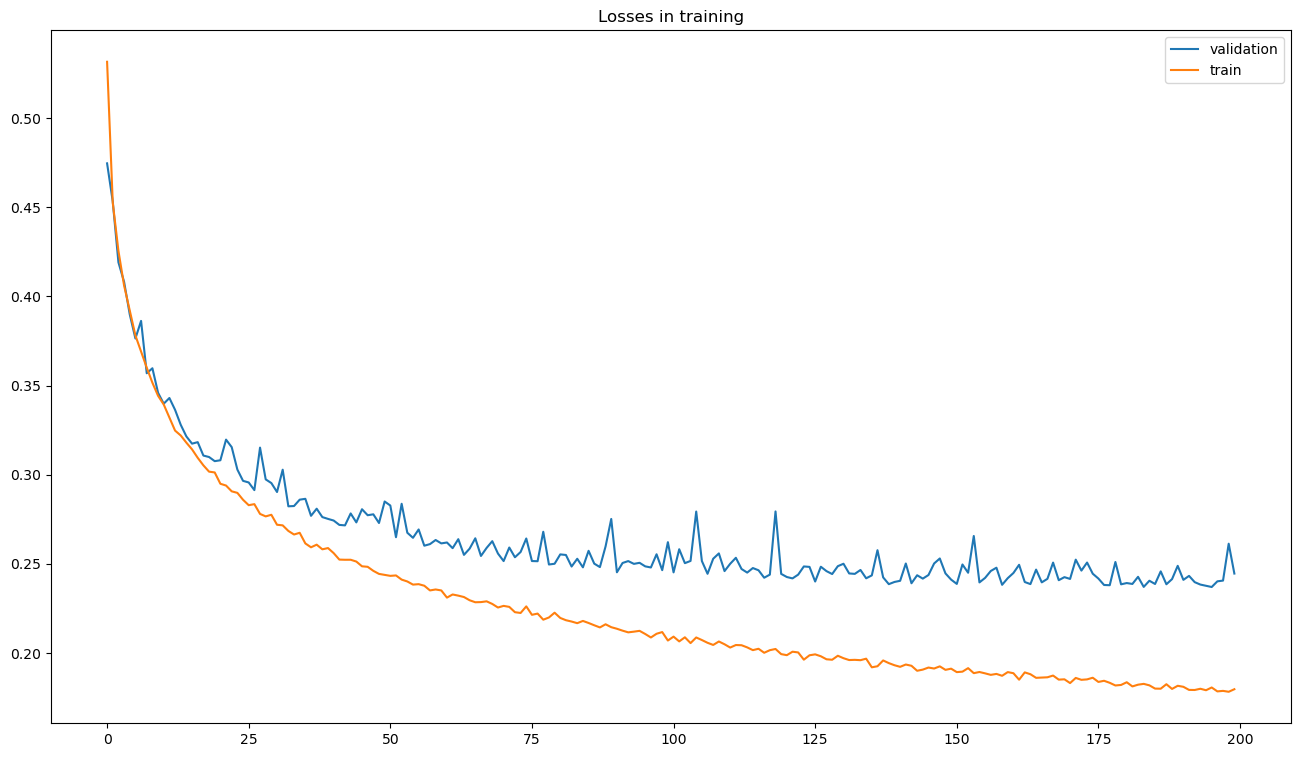

In [ ]:
plt.figure(figsize=(16,9))
plt.plot(losses_val, label='validation')
plt.plot(losses_train, label='train')
plt.legend()
plt.title("Losses in training")

In [57]:
# Define a file path to save the state to
file_path = 'acc90-loss0_24.pth'

# Get the network's state dictionary
state = model.state_dict()

# Save the state dictionary to a file
torch.save(state, file_path)